# Comparing train data segmention measurments to manual measurments

This notebook explores how well vein length measurements extracted from the the neural network segmentations of the training correlate with manual measurments

This compares the human measured lengths with the lengths estimated by the neural network of images in the hold-out set. The hold-out set is 1 randomlly chosen replicate image from 100 randomally chosen genotypes (100 images total). These images were not used in training.

In [1]:
import sys
import os
from os.path import join, basename
from pathlib import Path
import matplotlib.pyplot as plt

project_root = os.path.abspath('../')

## Plot the results

In [4]:
import pandas as pd
import sqlite3
import warnings


conn = sqlite3.connect('../data/processed/final_lengths_validation_smoothed_1900_CE04_T01.sqlite')
conn_man = sqlite3.connect('../reports/data/results.sqlite')

df_data = pd.read_sql("SELECT * FROM vein_lengths",conn)
# df_train = pd.read_sql("SELECT * FROM v3_train_vein_length",conn)
df_human = pd.read_sql("SELECT * FROM manually_measured",conn_man)

def plot_scatter(df):
    if df[['length_measured','length_human']].isna().values.any():
        warnings.warn("NA values detected, they will be dropped")
        df = df.dropna()

    #Plot Scatter data
    plt.scatter(df['length_measured'],df['length_human'])
    plt.xlabel('AI Measured Vein Length (pixels)')
    plt.ylabel(r'Human Measured Vein Length ($\mu$m)')

    #Add correlation information
    r =  df[['length_measured','length_human']].corr()['length_measured'][1]
    plt.text(28000, 17500, r"$r$ = %1.5f"%(r,))
    print(r)

0.9264482139145149


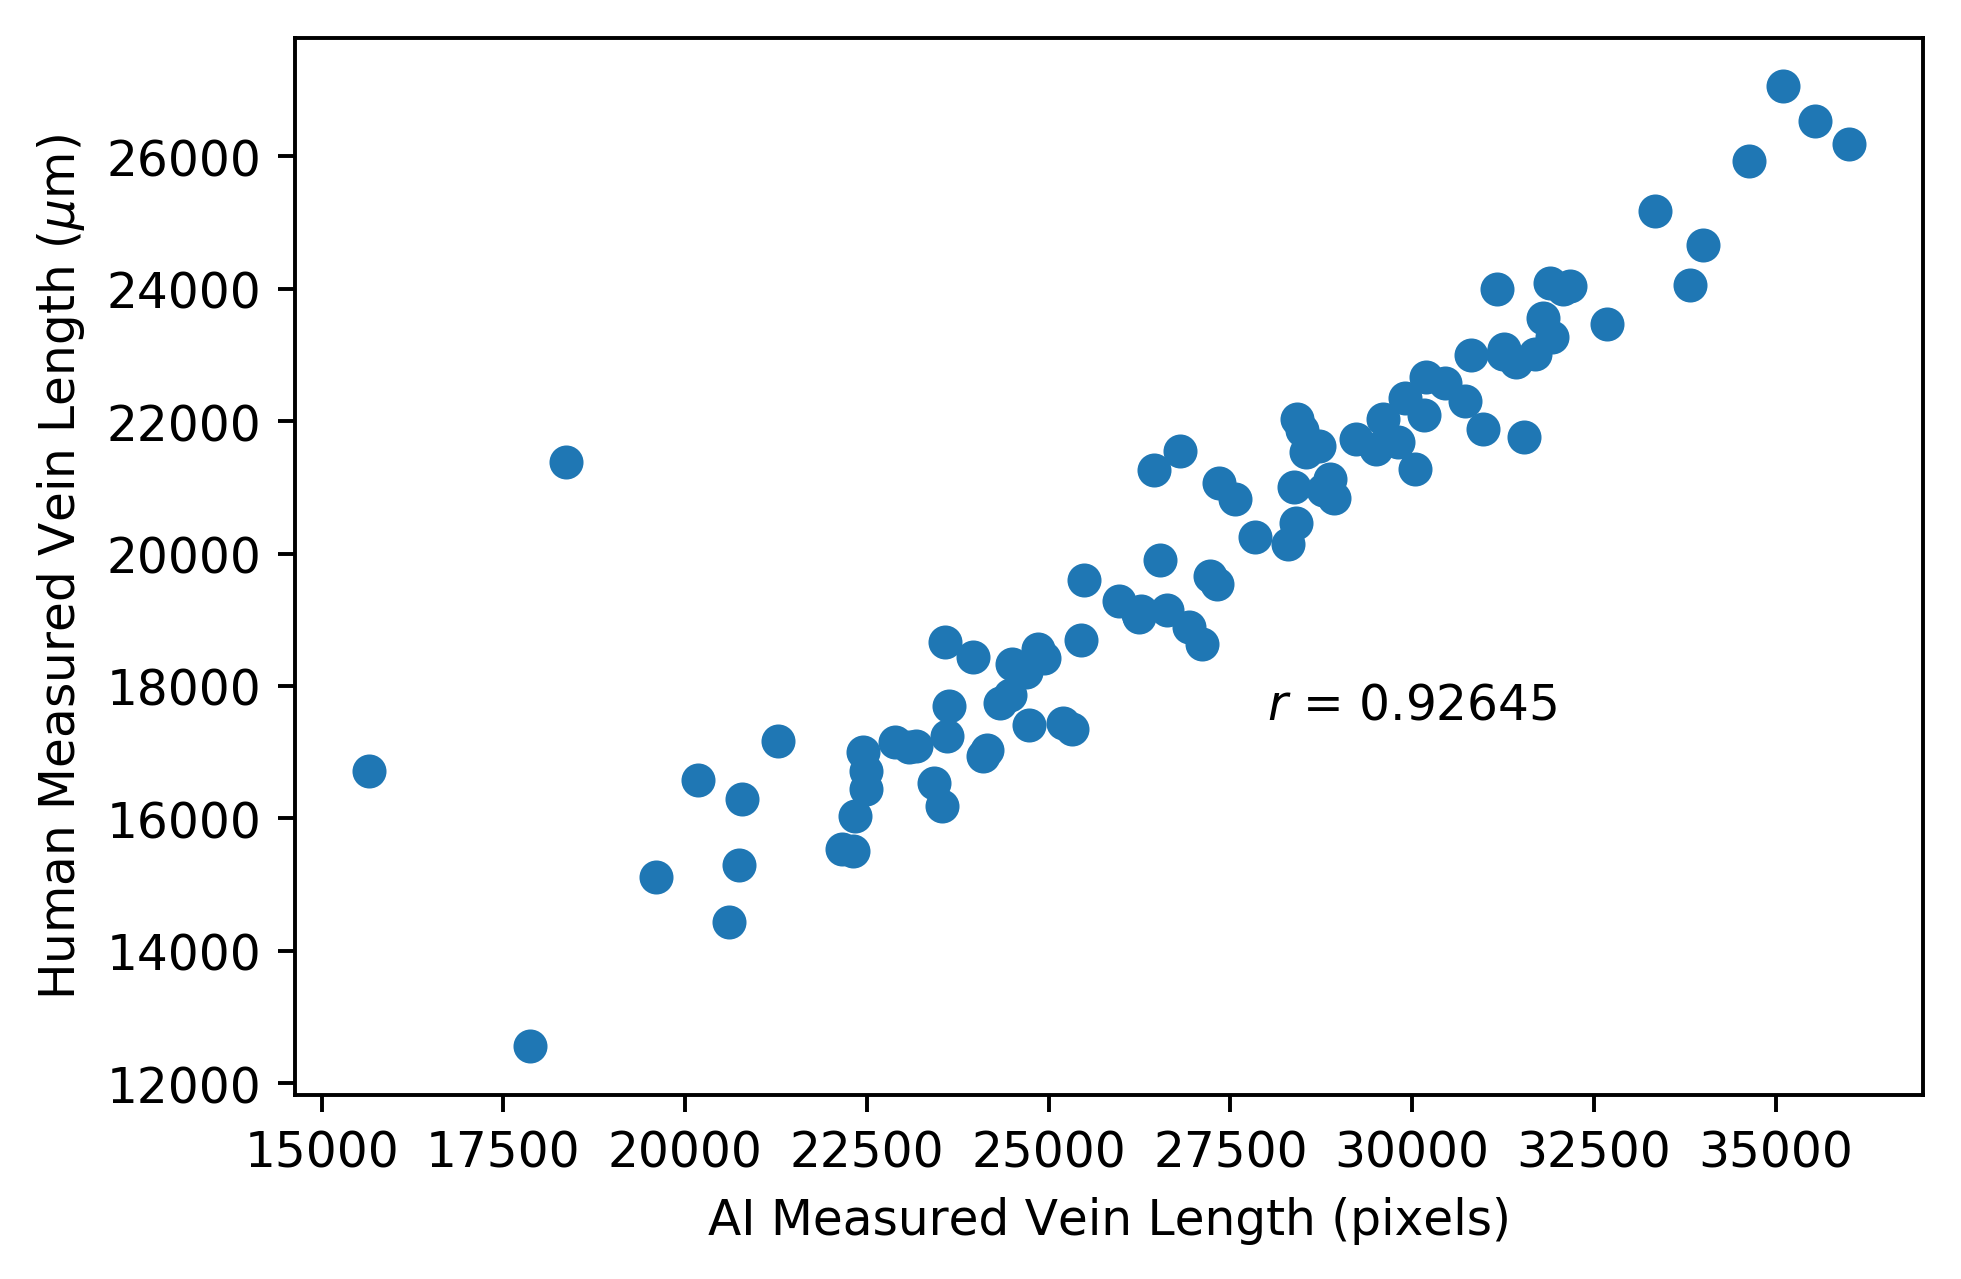

In [5]:

df_data_merged = df_data.merge(df_human[['plant','replicate','length']],
                           on=["plant","replicate"],
                           how="inner",
                           suffixes=("_measured","_human"),
                           validate="one_to_one")
plt.figure(dpi=350)    
plot_scatter(df_data_merged)

## Explore the model error

Histogram of the errors between the human measured and predicted vein length.

$$ error_i = (x_i-y_i) - \frac{1}{N} \sum_{i=1}^{N} (x_i - y_i) $$

where $x_i$ is the human measured vein length and $y_i$ is the AI measured vein length for sample $i$. 

__Note that the standard deviation and error have no useful units.__ 

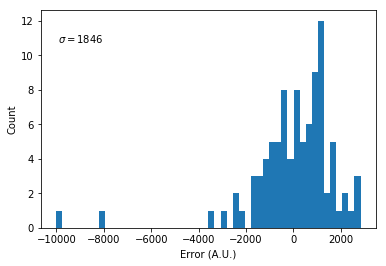

In [6]:
import numpy as np

error = df_data_merged['length_measured'] - df_data_merged['length_human']
error = error - error.mean()

plt.hist(error,50);
plt.xlabel(r'Error (A.U.)')
plt.ylabel('Count')

std = np.std(error)
plt.annotate(r"$\sigma = %0.0f$"%(std,), 
             xy=(0.05, 0.85), 
             xycoords='axes fraction');

## Poorly segmented images

- I defined outliers as measured predictions that were off from the manually measured by more than $3\sigma$ 
- The table naming scheme from the image file names is [plant]-[replicate].jpg

In [7]:
outliers_idx = np.where(error**2 > (std**2 * 3))

print(r"Outliers with an error greater than %0.0f:"%(std * 3,))
outliers = df_data_merged.iloc[outliers_idx].copy()
outliers['error'] = error.iloc[outliers_idx]
outliers[['plant','replicate','length_measured','length_human','error']]

Outliers with an error greater than 5539:


,plant,replicate,length_measured,length_human,error
1,102,8,18355,21384.907,-10008.084548
84,8,3,15656,16718.336,-8040.513548
89,91,6,20172,16572.474,-3378.651548


# Find Accuracy with outliers removed

Recalculate the accuracy with these images removed.

Visual inspection of the outlier images reveals most are incorrectly segmented due to image quality. Removeing these images should be easy to accomplish via manual inspection after segementation. 

The large increase in accuracy suggests that a few badly segmented images affect the overall accuracy to a large extent. 

0.9747690480922868


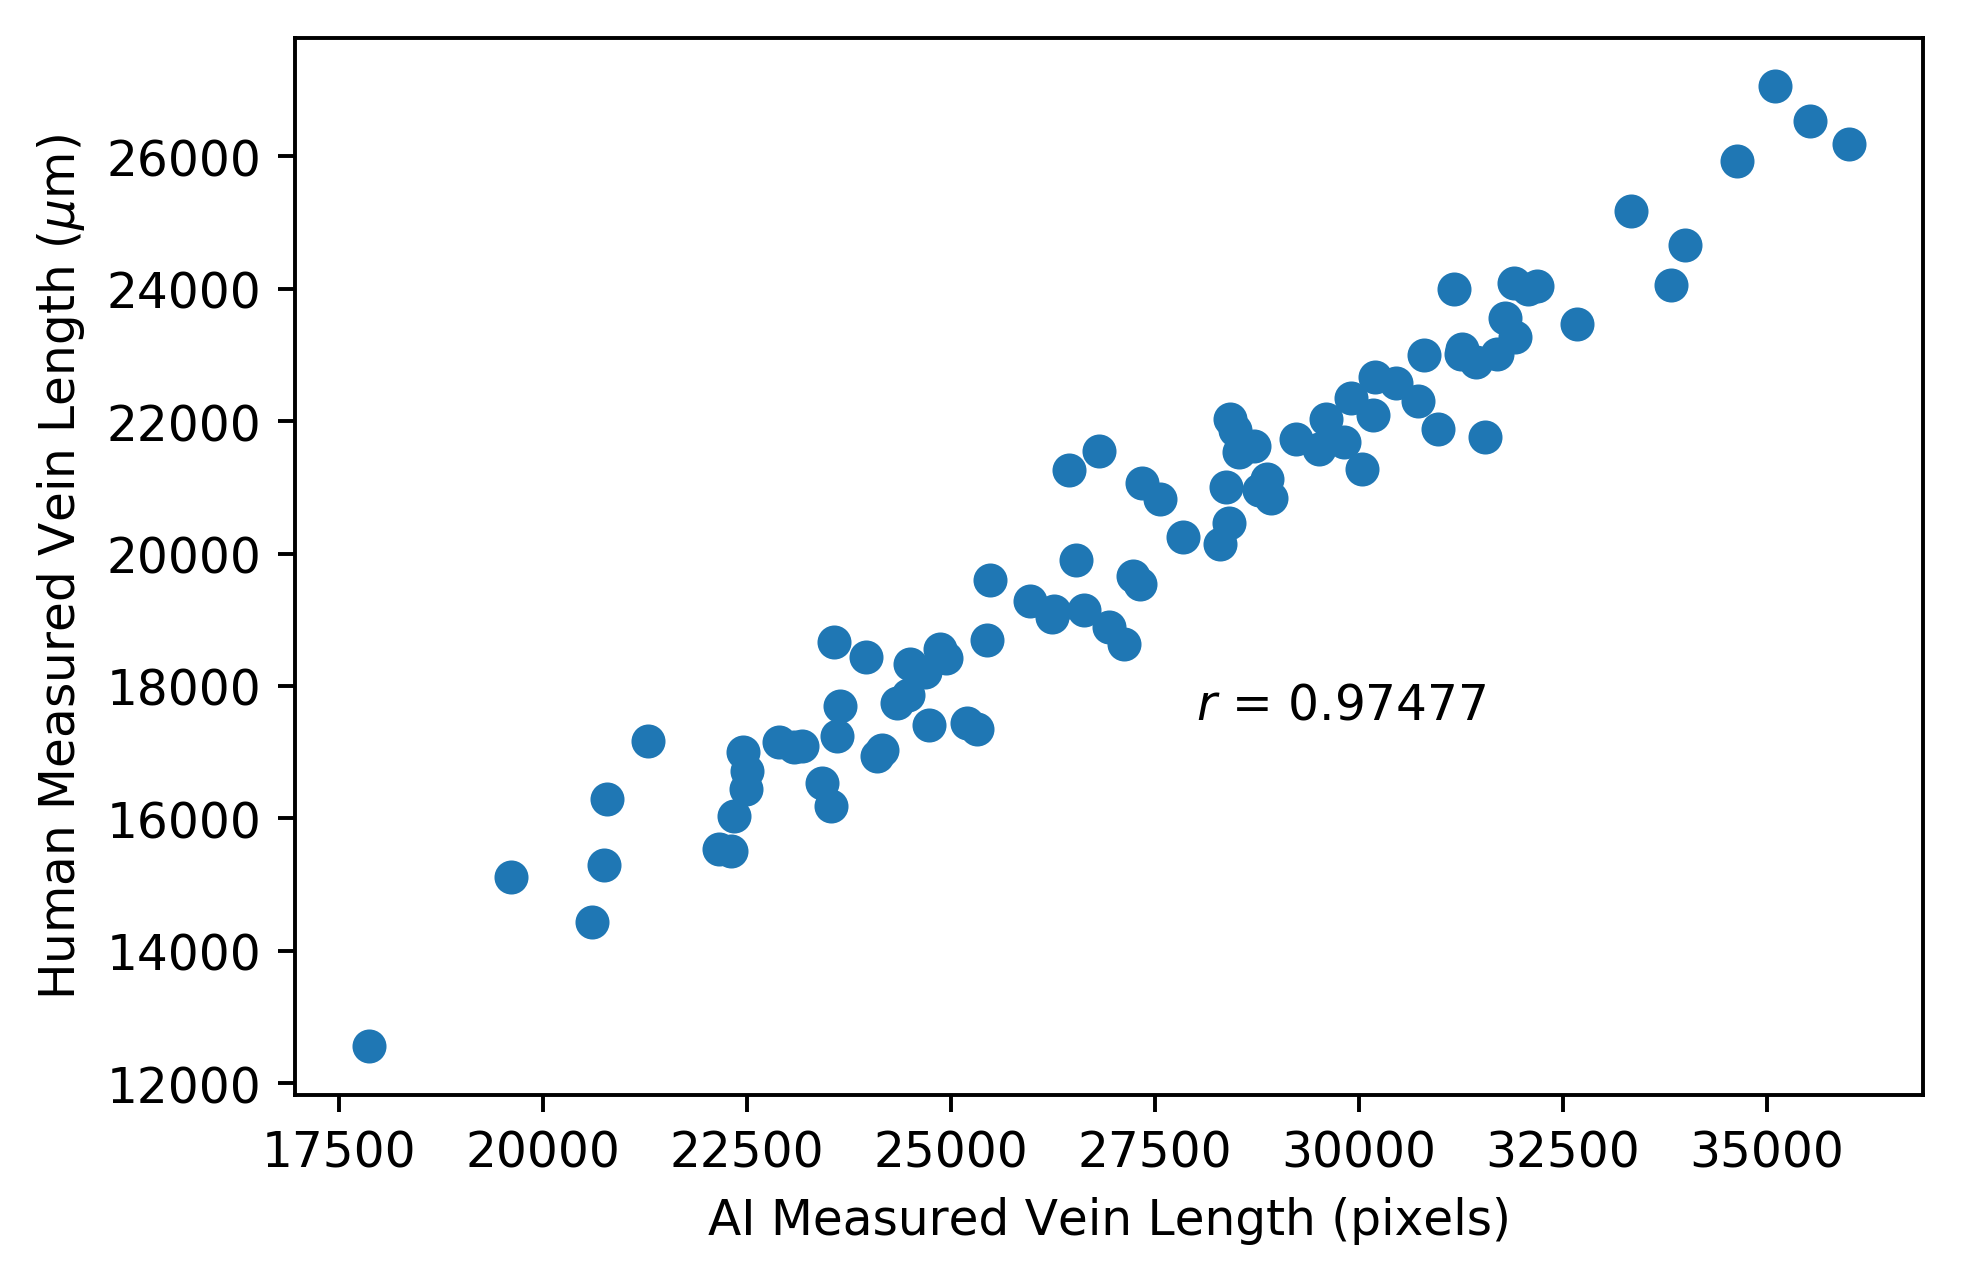

In [8]:
idx = np.where(error**2 <= (std**2 * 3))

plt.figure(dpi=350)    
plot_scatter(df_data_merged.iloc[idx])